In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [161]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [3]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [5]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.58245e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.36s/it]


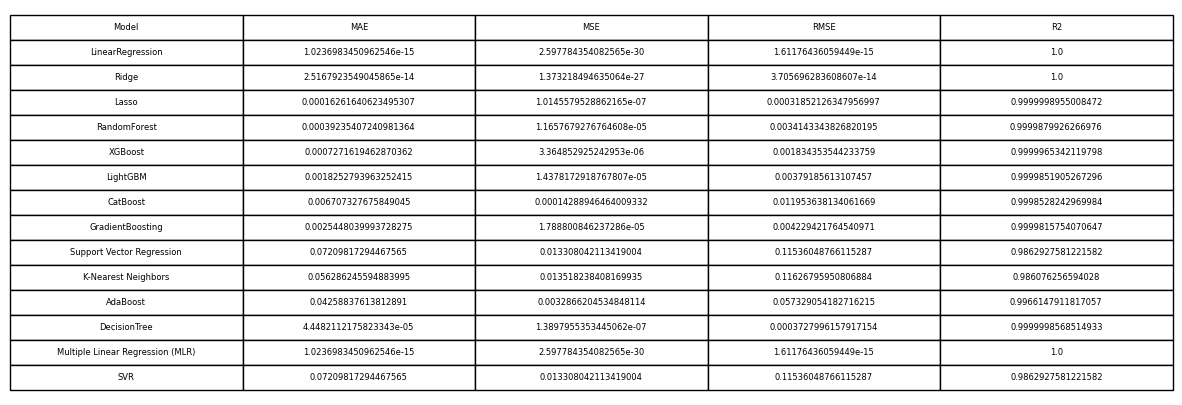

In [6]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()

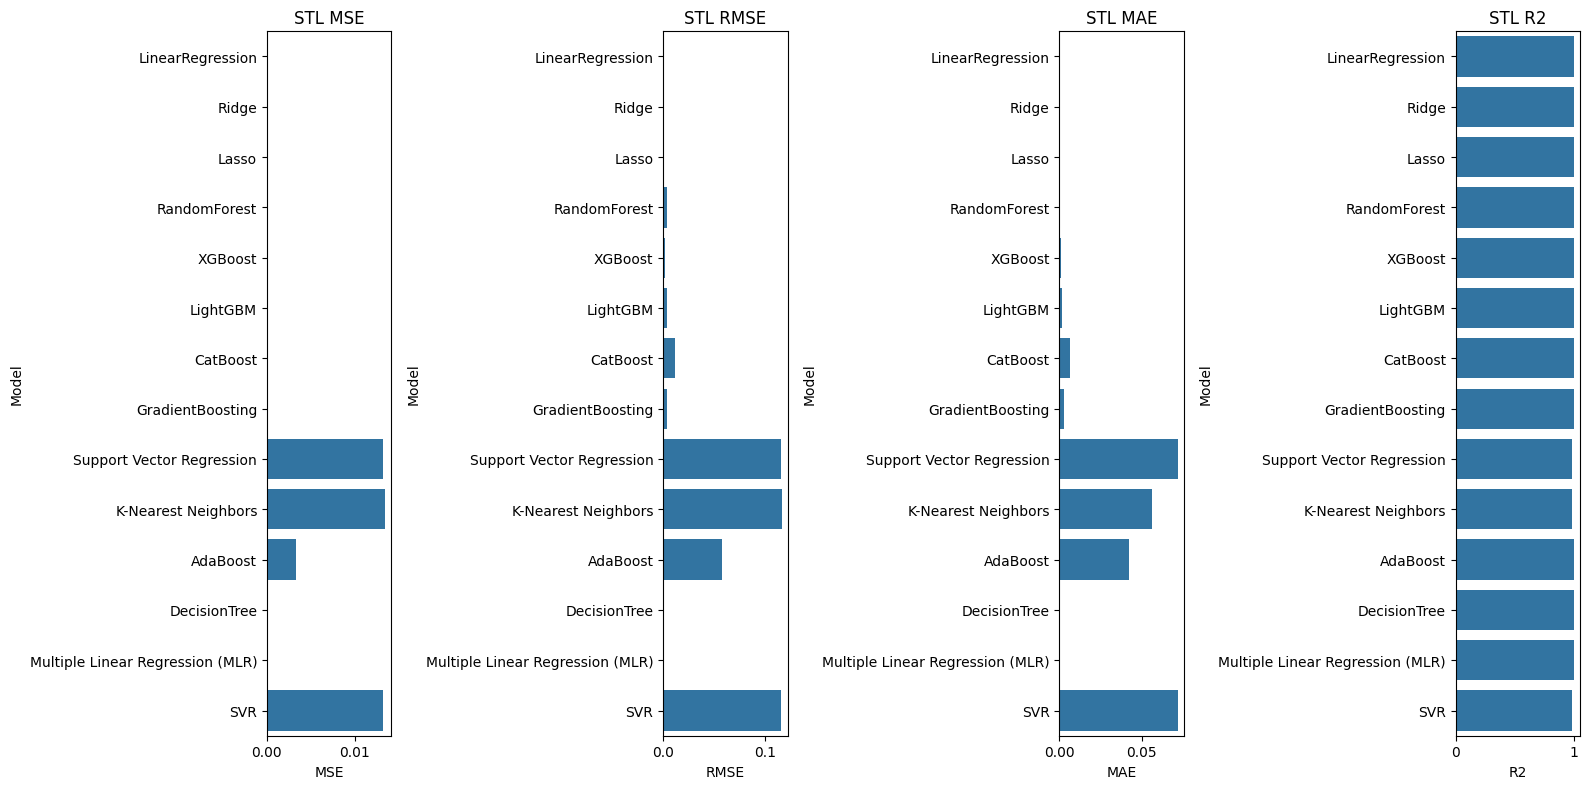

In [7]:
plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()

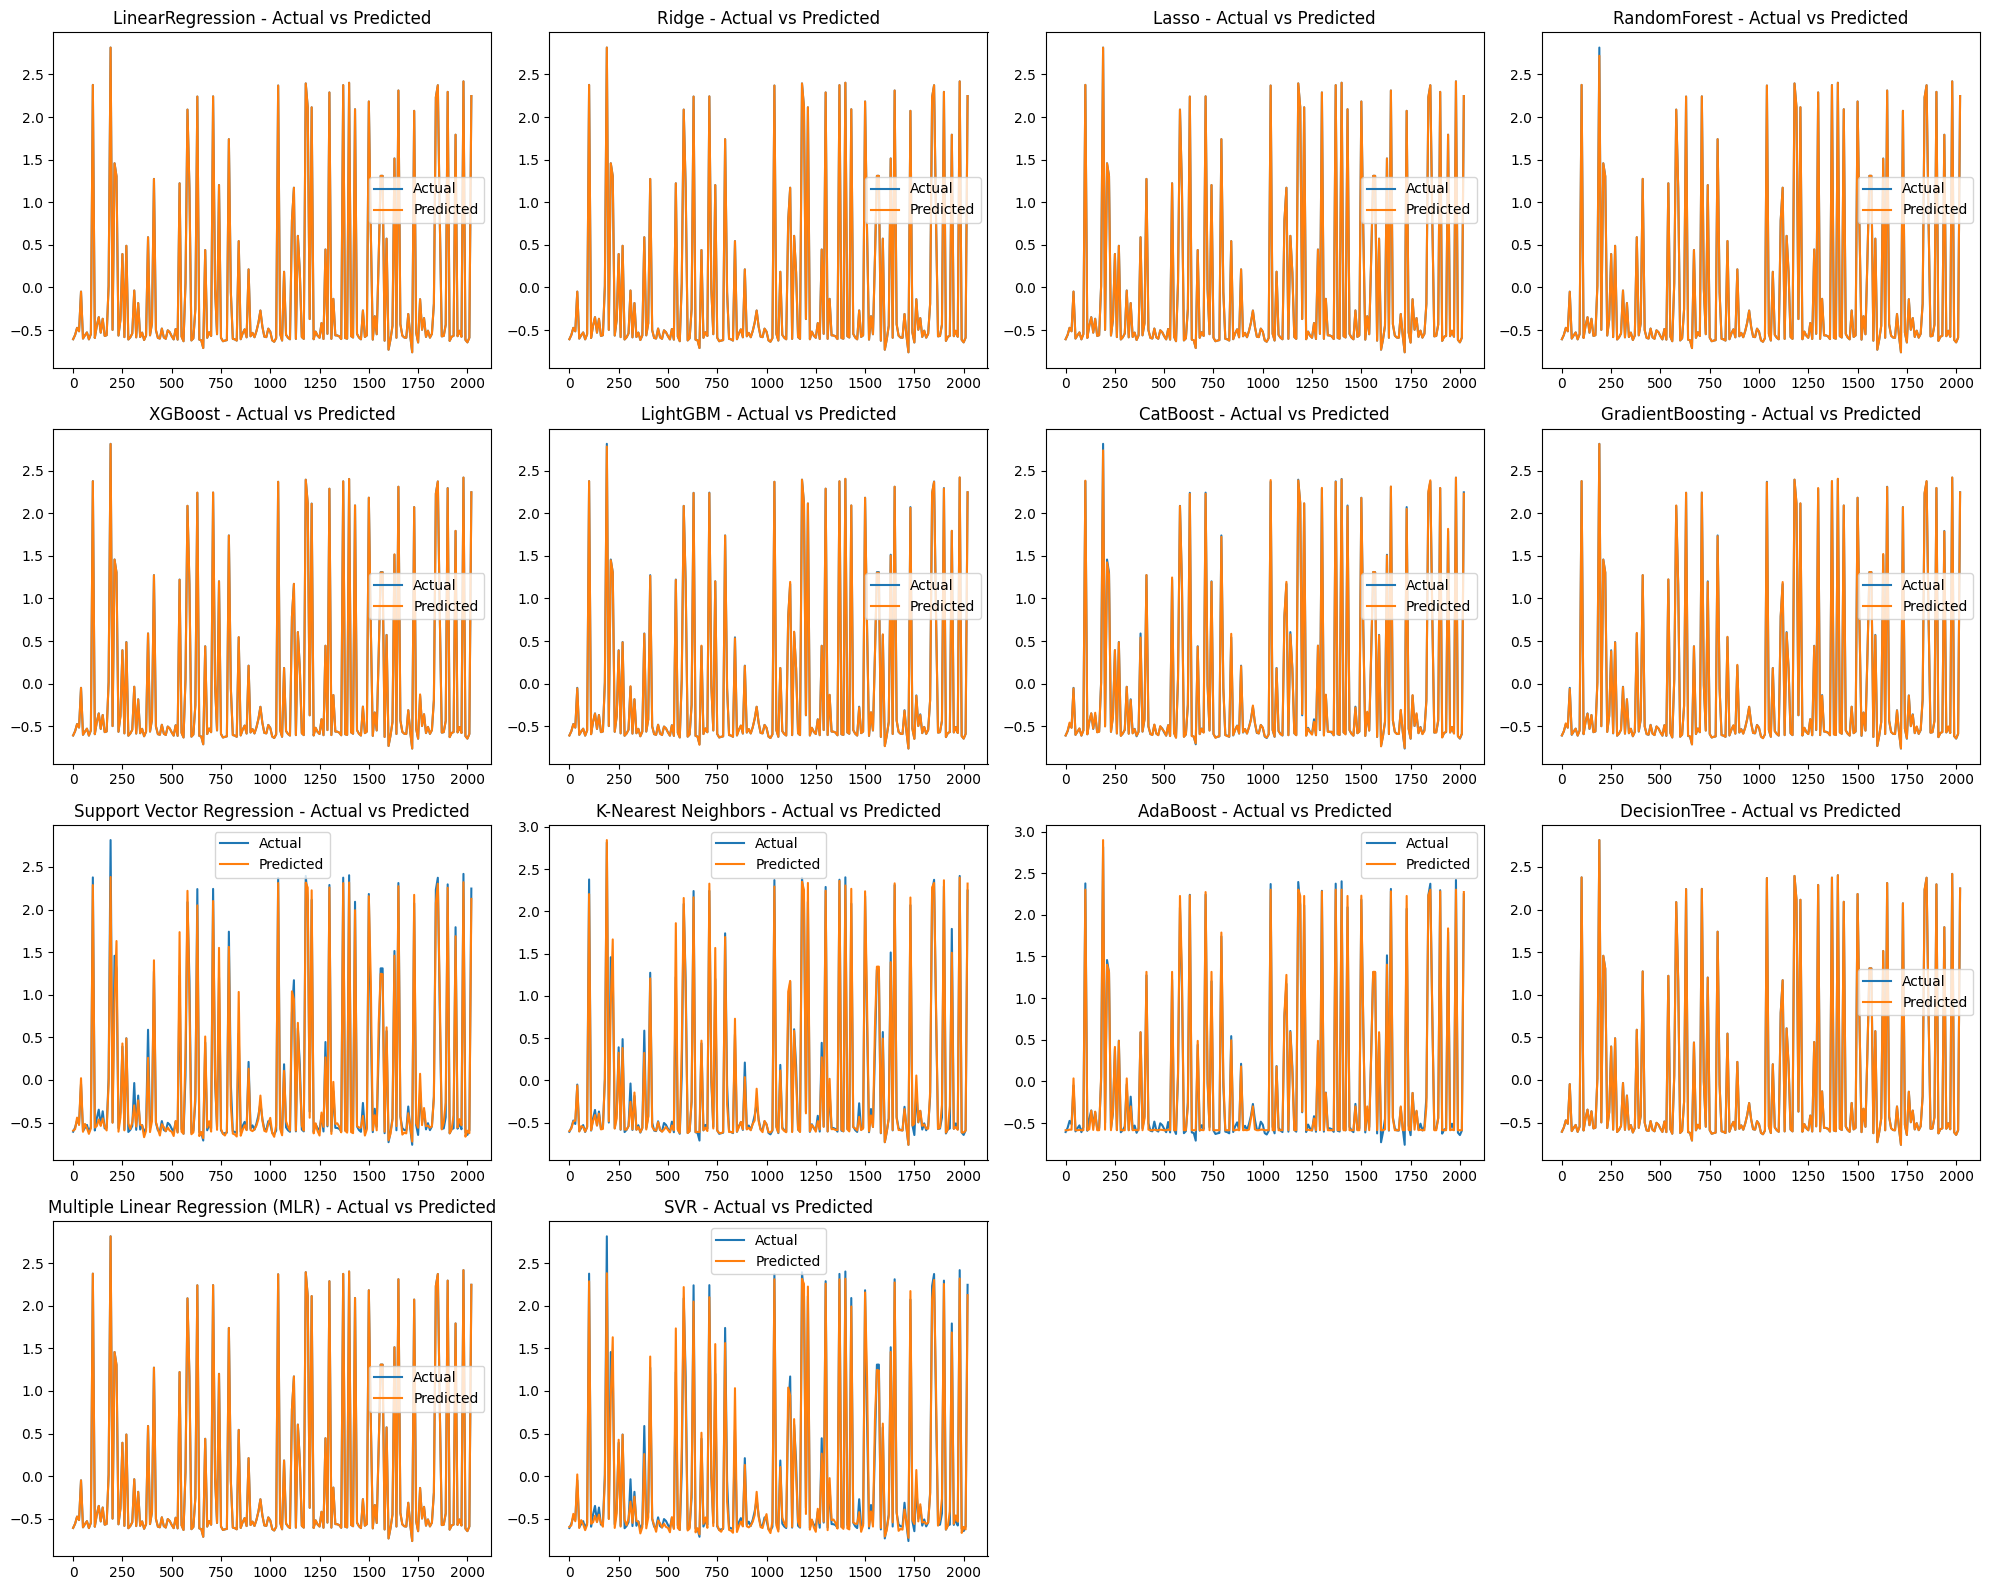

In [8]:
cols_stl      = 4
num_models_stl = len(results)
rows_stl      = int(np.ceil(num_models_stl / cols_stl))

idx = np.arange(len(y_test))[::10]

plt.figure(figsize=(20, 16))
for i, (name, res) in enumerate(results.items()):
    ax = plt.subplot(rows_stl, cols_stl, i + 1)
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend()
plt.tight_layout()
plt.show()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [32]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [10]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [11]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [62]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [63]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [181]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [65]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

  2%|██                                                                                                     | 2/100 [00:00<00:16,  6.08it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.0095, RMSE: 0.0976, MAE: 0.0706, R2: 0.9905
Test:  MSE: 0.0100, RMSE: 0.1002, MAE: 0.0724, R2: 0.9897


 10%|██████████▏                                                                                           | 10/100 [00:01<00:08, 10.17it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0004, RMSE: 0.0209, MAE: 0.0147, R2: 0.9996
Test:  MSE: 0.0004, RMSE: 0.0208, MAE: 0.0144, R2: 0.9996


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:09,  8.70it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0136, MAE: 0.0095, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0145, MAE: 0.0099, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:08,  8.55it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0080, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  8.61it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0103, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0085, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:05,  8.79it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0076, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0088, MAE: 0.0064, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:07<00:04,  8.19it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0072, MAE: 0.0052, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0081, MAE: 0.0056, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:08<00:03,  8.44it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0064, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0073, MAE: 0.0055, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:09<00:02,  8.67it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0054, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0082, MAE: 0.0056, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:01,  8.36it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0047, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0056, MAE: 0.0039, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.50it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0057, MAE: 0.0042, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0065, MAE: 0.0045, R2: 1.0000


  1%|█                                                                                                      | 1/100 [00:00<00:14,  6.89it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0017, RMSE: 0.0413, MAE: 0.0299, R2: 0.9983
Test:  MSE: 0.0018, RMSE: 0.0425, MAE: 0.0311, R2: 0.9981


 11%|███████████▏                                                                                          | 11/100 [00:01<00:12,  6.88it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0001, RMSE: 0.0112, MAE: 0.0087, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0129, MAE: 0.0096, R2: 0.9998


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:11,  6.96it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0100, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0111, MAE: 0.0076, R2: 0.9999


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:09,  7.14it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0002, RMSE: 0.0128, MAE: 0.0091, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0093, R2: 0.9998


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:05<00:08,  7.06it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0107, MAE: 0.0083, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0086, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:07<00:07,  6.99it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0101, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0090, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:08<00:05,  7.12it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0062, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0051, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:10<00:04,  7.12it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0037, MAE: 0.0027, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0049, MAE: 0.0033, R2: 1.0000


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:11<00:03,  6.26it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0070, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:13<00:01,  7.12it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0040, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0066, MAE: 0.0042, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.89it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0042, MAE: 0.0032, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0048, MAE: 0.0036, R2: 1.0000


  2%|██                                                                                                     | 2/100 [00:00<00:19,  4.96it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0014, RMSE: 0.0370, MAE: 0.0275, R2: 0.9986
Test:  MSE: 0.0014, RMSE: 0.0372, MAE: 0.0277, R2: 0.9986


 11%|███████████▏                                                                                          | 11/100 [00:02<00:19,  4.54it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0171, MAE: 0.0137, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0175, MAE: 0.0139, R2: 0.9997


 21%|█████████████████████▍                                                                                | 21/100 [00:04<00:15,  5.12it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0139, MAE: 0.0091, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0148, MAE: 0.0095, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:06<00:12,  5.34it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0086, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0094, MAE: 0.0067, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:08<00:11,  5.31it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0109, MAE: 0.0093, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0110, MAE: 0.0094, R2: 0.9999


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:09<00:09,  5.29it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0058, MAE: 0.0039, R2: 1.0000


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:11<00:07,  5.17it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0070, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0079, MAE: 0.0049, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:14<00:05,  5.28it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0082, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0089, MAE: 0.0062, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:16<00:03,  5.01it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0035, MAE: 0.0025, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0044, MAE: 0.0029, R2: 1.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:18<00:01,  5.20it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0049, MAE: 0.0038, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0056, MAE: 0.0040, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.00it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0062, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0064, MAE: 0.0054, R2: 1.0000


  1%|█                                                                                                      | 1/100 [00:00<00:50,  1.98it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0205, RMSE: 0.1430, MAE: 0.1073, R2: 0.9797
Test:  MSE: 0.0199, RMSE: 0.1410, MAE: 0.1057, R2: 0.9795


 10%|██████████▏                                                                                           | 10/100 [00:04<00:38,  2.32it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0034, RMSE: 0.0579, MAE: 0.0456, R2: 0.9967
Test:  MSE: 0.0036, RMSE: 0.0597, MAE: 0.0451, R2: 0.9963


 20%|████████████████████▍                                                                                 | 20/100 [00:08<00:35,  2.28it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0096, RMSE: 0.0981, MAE: 0.0662, R2: 0.9904
Test:  MSE: 0.0096, RMSE: 0.0979, MAE: 0.0660, R2: 0.9901


 30%|██████████████████████████████▌                                                                       | 30/100 [00:13<00:30,  2.29it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0152, RMSE: 0.1235, MAE: 0.0810, R2: 0.9849
Test:  MSE: 0.0147, RMSE: 0.1213, MAE: 0.0795, R2: 0.9848


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:17<00:26,  2.27it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0054, RMSE: 0.0738, MAE: 0.0488, R2: 0.9946
Test:  MSE: 0.0056, RMSE: 0.0747, MAE: 0.0493, R2: 0.9942


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:21<00:20,  2.40it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0080, RMSE: 0.0896, MAE: 0.0525, R2: 0.9920
Test:  MSE: 0.0078, RMSE: 0.0885, MAE: 0.0515, R2: 0.9919


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:26<00:17,  2.28it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0153, RMSE: 0.1236, MAE: 0.0699, R2: 0.9848
Test:  MSE: 0.0148, RMSE: 0.1218, MAE: 0.0690, R2: 0.9847


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:30<00:13,  2.15it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0158, RMSE: 0.1258, MAE: 0.0687, R2: 0.9843
Test:  MSE: 0.0149, RMSE: 0.1223, MAE: 0.0661, R2: 0.9846


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:35<00:08,  2.29it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0105, RMSE: 0.1023, MAE: 0.0651, R2: 0.9896
Test:  MSE: 0.0100, RMSE: 0.0998, MAE: 0.0633, R2: 0.9897


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:39<00:04,  2.29it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0147, RMSE: 0.1214, MAE: 0.0663, R2: 0.9854
Test:  MSE: 0.0142, RMSE: 0.1190, MAE: 0.0650, R2: 0.9854


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.27it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0133, RMSE: 0.1155, MAE: 0.0654, R2: 0.9868
Test:  MSE: 0.0129, RMSE: 0.1136, MAE: 0.0642, R2: 0.9867


In [182]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  2%|██                                                                                                     | 2/100 [00:00<00:08, 11.35it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.1006, RMSE: 0.3172, MAE: 0.2090, R2: 0.9001
Test:  MSE: 0.0945, RMSE: 0.3075, MAE: 0.2028, R2: 0.9026


 11%|███████████▏                                                                                          | 11/100 [00:01<00:07, 11.33it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0016, RMSE: 0.0398, MAE: 0.0282, R2: 0.9984
Test:  MSE: 0.0018, RMSE: 0.0420, MAE: 0.0292, R2: 0.9982


 21%|█████████████████████▍                                                                                | 21/100 [00:01<00:06, 12.56it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0006, RMSE: 0.0253, MAE: 0.0174, R2: 0.9994
Test:  MSE: 0.0007, RMSE: 0.0267, MAE: 0.0182, R2: 0.9993


 31%|███████████████████████████████▌                                                                      | 31/100 [00:02<00:05, 12.17it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0004, RMSE: 0.0192, MAE: 0.0132, R2: 0.9996
Test:  MSE: 0.0004, RMSE: 0.0200, MAE: 0.0138, R2: 0.9996


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:03<00:04, 12.40it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0161, MAE: 0.0112, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0173, MAE: 0.0119, R2: 0.9997


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:04<00:03, 12.48it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0140, MAE: 0.0097, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0154, MAE: 0.0106, R2: 0.9998


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:05<00:04,  8.64it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0128, MAE: 0.0089, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0146, MAE: 0.0100, R2: 0.9998


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:06<00:02, 11.48it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0115, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0133, MAE: 0.0091, R2: 0.9998


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:06<00:01, 12.82it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0106, MAE: 0.0074, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0124, MAE: 0.0083, R2: 0.9998


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:07<00:00, 13.10it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0078, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.86it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0065, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0110, MAE: 0.0074, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:09, 10.55it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0237, RMSE: 0.1538, MAE: 0.1163, R2: 0.9765
Test:  MSE: 0.0241, RMSE: 0.1552, MAE: 0.1160, R2: 0.9752


 12%|████████████▏                                                                                         | 12/100 [00:01<00:07, 11.27it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0004, RMSE: 0.0199, MAE: 0.0141, R2: 0.9996
Test:  MSE: 0.0004, RMSE: 0.0206, MAE: 0.0146, R2: 0.9996


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:06, 11.24it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0127, MAE: 0.0090, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0141, MAE: 0.0095, R2: 0.9998


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:06, 10.65it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0096, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0114, MAE: 0.0075, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:05, 11.13it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0072, R2: 0.9999


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:04<00:04, 11.30it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0073, MAE: 0.0053, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0094, MAE: 0.0061, R2: 0.9999


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:05<00:03, 11.23it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0065, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0088, MAE: 0.0056, R2: 0.9999


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:06<00:02, 10.58it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0060, MAE: 0.0043, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0083, MAE: 0.0052, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:07<00:01,  9.61it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0055, MAE: 0.0039, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0079, MAE: 0.0047, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:08<00:00, 10.26it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0053, MAE: 0.0039, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0078, MAE: 0.0048, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.59it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0073, MAE: 0.0044, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:11,  8.86it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0106, RMSE: 0.1031, MAE: 0.0833, R2: 0.9895
Test:  MSE: 0.0111, RMSE: 0.1054, MAE: 0.0856, R2: 0.9886


 11%|███████████▏                                                                                          | 11/100 [00:01<00:10,  8.87it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0160, MAE: 0.0116, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0171, MAE: 0.0121, R2: 0.9997


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:08,  8.99it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0091, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0074, R2: 0.9999


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:07,  9.07it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0049, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0085, MAE: 0.0055, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  9.22it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0000, RMSE: 0.0063, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0080, MAE: 0.0054, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:05,  9.46it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0054, MAE: 0.0042, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0076, MAE: 0.0050, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:06<00:04,  9.43it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0056, MAE: 0.0045, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0052, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:07<00:03,  9.14it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0056, MAE: 0.0046, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0072, MAE: 0.0052, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:08<00:02,  9.27it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0077, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0107, MAE: 0.0082, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:01,  6.89it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0077, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0085, MAE: 0.0063, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.69it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0035, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0061, MAE: 0.0041, R2: 1.0000


  1%|█                                                                                                      | 1/100 [00:00<00:26,  3.76it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0061, RMSE: 0.0779, MAE: 0.0594, R2: 0.9940
Test:  MSE: 0.0062, RMSE: 0.0790, MAE: 0.0600, R2: 0.9936


 10%|██████████▏                                                                                           | 10/100 [00:02<00:23,  3.86it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0055, RMSE: 0.0740, MAE: 0.0466, R2: 0.9946
Test:  MSE: 0.0054, RMSE: 0.0735, MAE: 0.0463, R2: 0.9944


 20%|████████████████████▍                                                                                 | 20/100 [00:05<00:21,  3.66it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0086, RMSE: 0.0929, MAE: 0.0601, R2: 0.9914
Test:  MSE: 0.0088, RMSE: 0.0937, MAE: 0.0606, R2: 0.9910


 30%|██████████████████████████████▌                                                                       | 30/100 [00:07<00:17,  3.89it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0126, RMSE: 0.1123, MAE: 0.0690, R2: 0.9875
Test:  MSE: 0.0126, RMSE: 0.1121, MAE: 0.0689, R2: 0.9871


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:10<00:14,  4.03it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0149, RMSE: 0.1219, MAE: 0.0763, R2: 0.9853
Test:  MSE: 0.0144, RMSE: 0.1201, MAE: 0.0755, R2: 0.9852


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:13<00:14,  3.41it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0163, RMSE: 0.1278, MAE: 0.0814, R2: 0.9838
Test:  MSE: 0.0159, RMSE: 0.1261, MAE: 0.0804, R2: 0.9836


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:15<00:11,  3.54it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0112, RMSE: 0.1057, MAE: 0.0746, R2: 0.9889
Test:  MSE: 0.0109, RMSE: 0.1043, MAE: 0.0733, R2: 0.9888


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:18<00:07,  3.94it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0139, RMSE: 0.1179, MAE: 0.0652, R2: 0.9862
Test:  MSE: 0.0136, RMSE: 0.1165, MAE: 0.0648, R2: 0.9860


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:21<00:04,  4.12it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0097, RMSE: 0.0982, MAE: 0.0739, R2: 0.9904
Test:  MSE: 0.0095, RMSE: 0.0975, MAE: 0.0729, R2: 0.9902


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:23<00:02,  4.00it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0132, RMSE: 0.1149, MAE: 0.0760, R2: 0.9869
Test:  MSE: 0.0127, RMSE: 0.1128, MAE: 0.0748, R2: 0.9869


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.84it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0207, RMSE: 0.1438, MAE: 0.0984, R2: 0.9795
Test:  MSE: 0.0197, RMSE: 0.1402, MAE: 0.0961, R2: 0.9797


  3%|███                                                                                                    | 3/100 [00:00<00:17,  5.66it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.0554, RMSE: 0.2354, MAE: 0.1938, R2: 0.9450
Test:  MSE: 0.0530, RMSE: 0.2302, MAE: 0.1879, R2: 0.9454


 12%|████████████▏                                                                                         | 12/100 [00:01<00:09,  9.13it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0078, RMSE: 0.0881, MAE: 0.0654, R2: 0.9923
Test:  MSE: 0.0076, RMSE: 0.0874, MAE: 0.0654, R2: 0.9921


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:08,  9.77it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0041, RMSE: 0.0642, MAE: 0.0467, R2: 0.9959
Test:  MSE: 0.0043, RMSE: 0.0655, MAE: 0.0475, R2: 0.9956


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:07,  9.24it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0053, RMSE: 0.0727, MAE: 0.0538, R2: 0.9947
Test:  MSE: 0.0054, RMSE: 0.0736, MAE: 0.0541, R2: 0.9944


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:04<00:06,  9.92it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0034, RMSE: 0.0580, MAE: 0.0438, R2: 0.9967
Test:  MSE: 0.0035, RMSE: 0.0595, MAE: 0.0445, R2: 0.9964


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:05,  9.54it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0048, RMSE: 0.0691, MAE: 0.0460, R2: 0.9953
Test:  MSE: 0.0050, RMSE: 0.0707, MAE: 0.0468, R2: 0.9949


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:06<00:04,  9.36it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0054, RMSE: 0.0737, MAE: 0.0505, R2: 0.9946
Test:  MSE: 0.0056, RMSE: 0.0745, MAE: 0.0509, R2: 0.9943


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:07<00:03,  9.85it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0039, RMSE: 0.0621, MAE: 0.0415, R2: 0.9962
Test:  MSE: 0.0040, RMSE: 0.0631, MAE: 0.0423, R2: 0.9959


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:08<00:01,  9.63it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0023, RMSE: 0.0475, MAE: 0.0336, R2: 0.9978
Test:  MSE: 0.0024, RMSE: 0.0494, MAE: 0.0346, R2: 0.9975


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:09<00:00,  9.65it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0027, RMSE: 0.0524, MAE: 0.0371, R2: 0.9973
Test:  MSE: 0.0029, RMSE: 0.0539, MAE: 0.0381, R2: 0.9970


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.33it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0043, RMSE: 0.0653, MAE: 0.0422, R2: 0.9958
Test:  MSE: 0.0042, RMSE: 0.0651, MAE: 0.0425, R2: 0.9956


  1%|█                                                                                                      | 1/100 [00:00<00:10,  9.16it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.1059, RMSE: 0.3255, MAE: 0.2248, R2: 0.8949
Test:  MSE: 0.1019, RMSE: 0.3192, MAE: 0.2228, R2: 0.8951


 11%|███████████▏                                                                                          | 11/100 [00:01<00:10,  8.50it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0068, RMSE: 0.0825, MAE: 0.0696, R2: 0.9932
Test:  MSE: 0.0070, RMSE: 0.0838, MAE: 0.0708, R2: 0.9928


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:09,  8.21it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0036, RMSE: 0.0604, MAE: 0.0449, R2: 0.9964
Test:  MSE: 0.0035, RMSE: 0.0594, MAE: 0.0445, R2: 0.9964


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:07,  8.70it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0029, RMSE: 0.0538, MAE: 0.0374, R2: 0.9971
Test:  MSE: 0.0029, RMSE: 0.0537, MAE: 0.0373, R2: 0.9970


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  8.80it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0056, RMSE: 0.0749, MAE: 0.0541, R2: 0.9944
Test:  MSE: 0.0053, RMSE: 0.0730, MAE: 0.0532, R2: 0.9945


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:06<00:05,  8.75it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0011, RMSE: 0.0333, MAE: 0.0241, R2: 0.9989
Test:  MSE: 0.0011, RMSE: 0.0335, MAE: 0.0245, R2: 0.9988


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:07<00:04,  9.07it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0045, RMSE: 0.0671, MAE: 0.0442, R2: 0.9955
Test:  MSE: 0.0044, RMSE: 0.0661, MAE: 0.0432, R2: 0.9955


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:08<00:03,  8.80it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0060, RMSE: 0.0772, MAE: 0.0597, R2: 0.9941
Test:  MSE: 0.0058, RMSE: 0.0760, MAE: 0.0587, R2: 0.9940


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:09<00:02,  8.61it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0032, RMSE: 0.0568, MAE: 0.0430, R2: 0.9968
Test:  MSE: 0.0032, RMSE: 0.0566, MAE: 0.0428, R2: 0.9967


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:01,  8.97it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0012, RMSE: 0.0348, MAE: 0.0240, R2: 0.9988
Test:  MSE: 0.0013, RMSE: 0.0355, MAE: 0.0242, R2: 0.9987


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.60it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0075, RMSE: 0.0867, MAE: 0.0628, R2: 0.9925
Test:  MSE: 0.0076, RMSE: 0.0874, MAE: 0.0634, R2: 0.9921


In [183]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [184]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     98   0.000017  0.000024    0.004173   0.004939   0.003063   
1  Net2     97   0.000011  0.000018    0.003366   0.004225   0.002597   
2  Net3     82   0.000009  0.000017    0.003005   0.004079   0.002110   
3  Net4     23   0.001571  0.001707    0.039641   0.041320   0.031229   

   Test MAE  Train R2   Test R2  
0  0.003352  0.999983  0.999975  
1  0.003037  0.999989  0.999982  
2  0.002456  0.999991  0.999983  
3  0.031476  0.998441  0.998241

In [185]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     50   0.001107  0.001123    0.033265   0.033514   0.024056   
1      FNN     81   0.002074  0.002231    0.045545   0.047229   0.032101   
2     Net1     98   0.000086  0.000121    0.009278   0.010988   0.006386   
3     Net2     96   0.000023  0.000052    0.004759   0.007209   0.003470   
4     Net3     99   0.000019  0.000033    0.004411   0.005745   0.003359   
5     Net4      3   0.002008  0.002024    0.044807   0.044994   0.032336   

   Test MAE  Train R2   Test R2  
0  0.024535  0.998902  0.998843  
1  0.033071  0.997942  0.997703  
2  0.007258  0.999915  0.999876  
3  0.004408  0.999978  0.999946  
4  0.004006  0.999981  0.999966  
5  0.033126  0.998008  0.997915

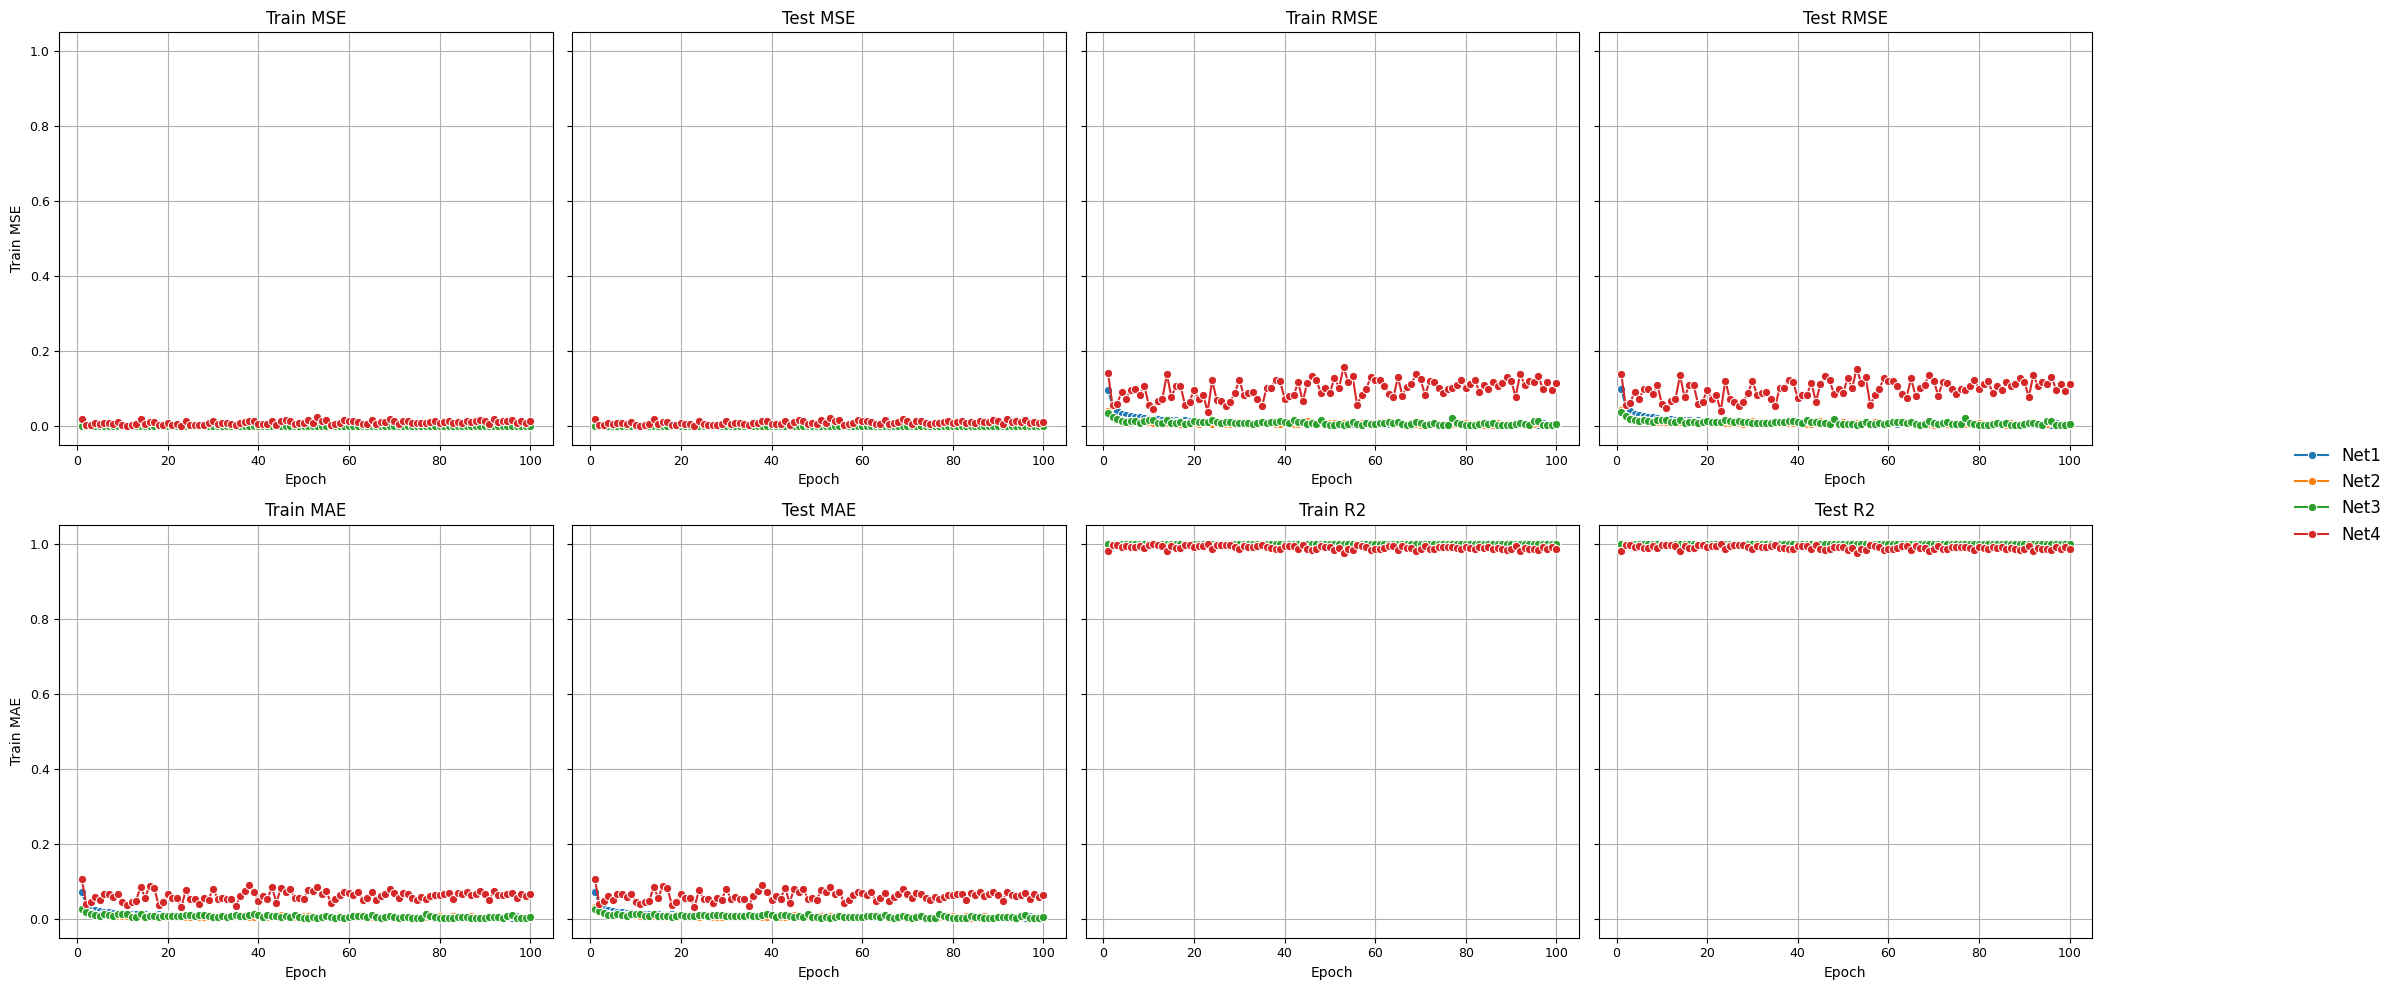

In [135]:
train_figures = {}
metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 
train_figures["Train_Metrics_Nets"] = fig

plt.show()
plt.close()

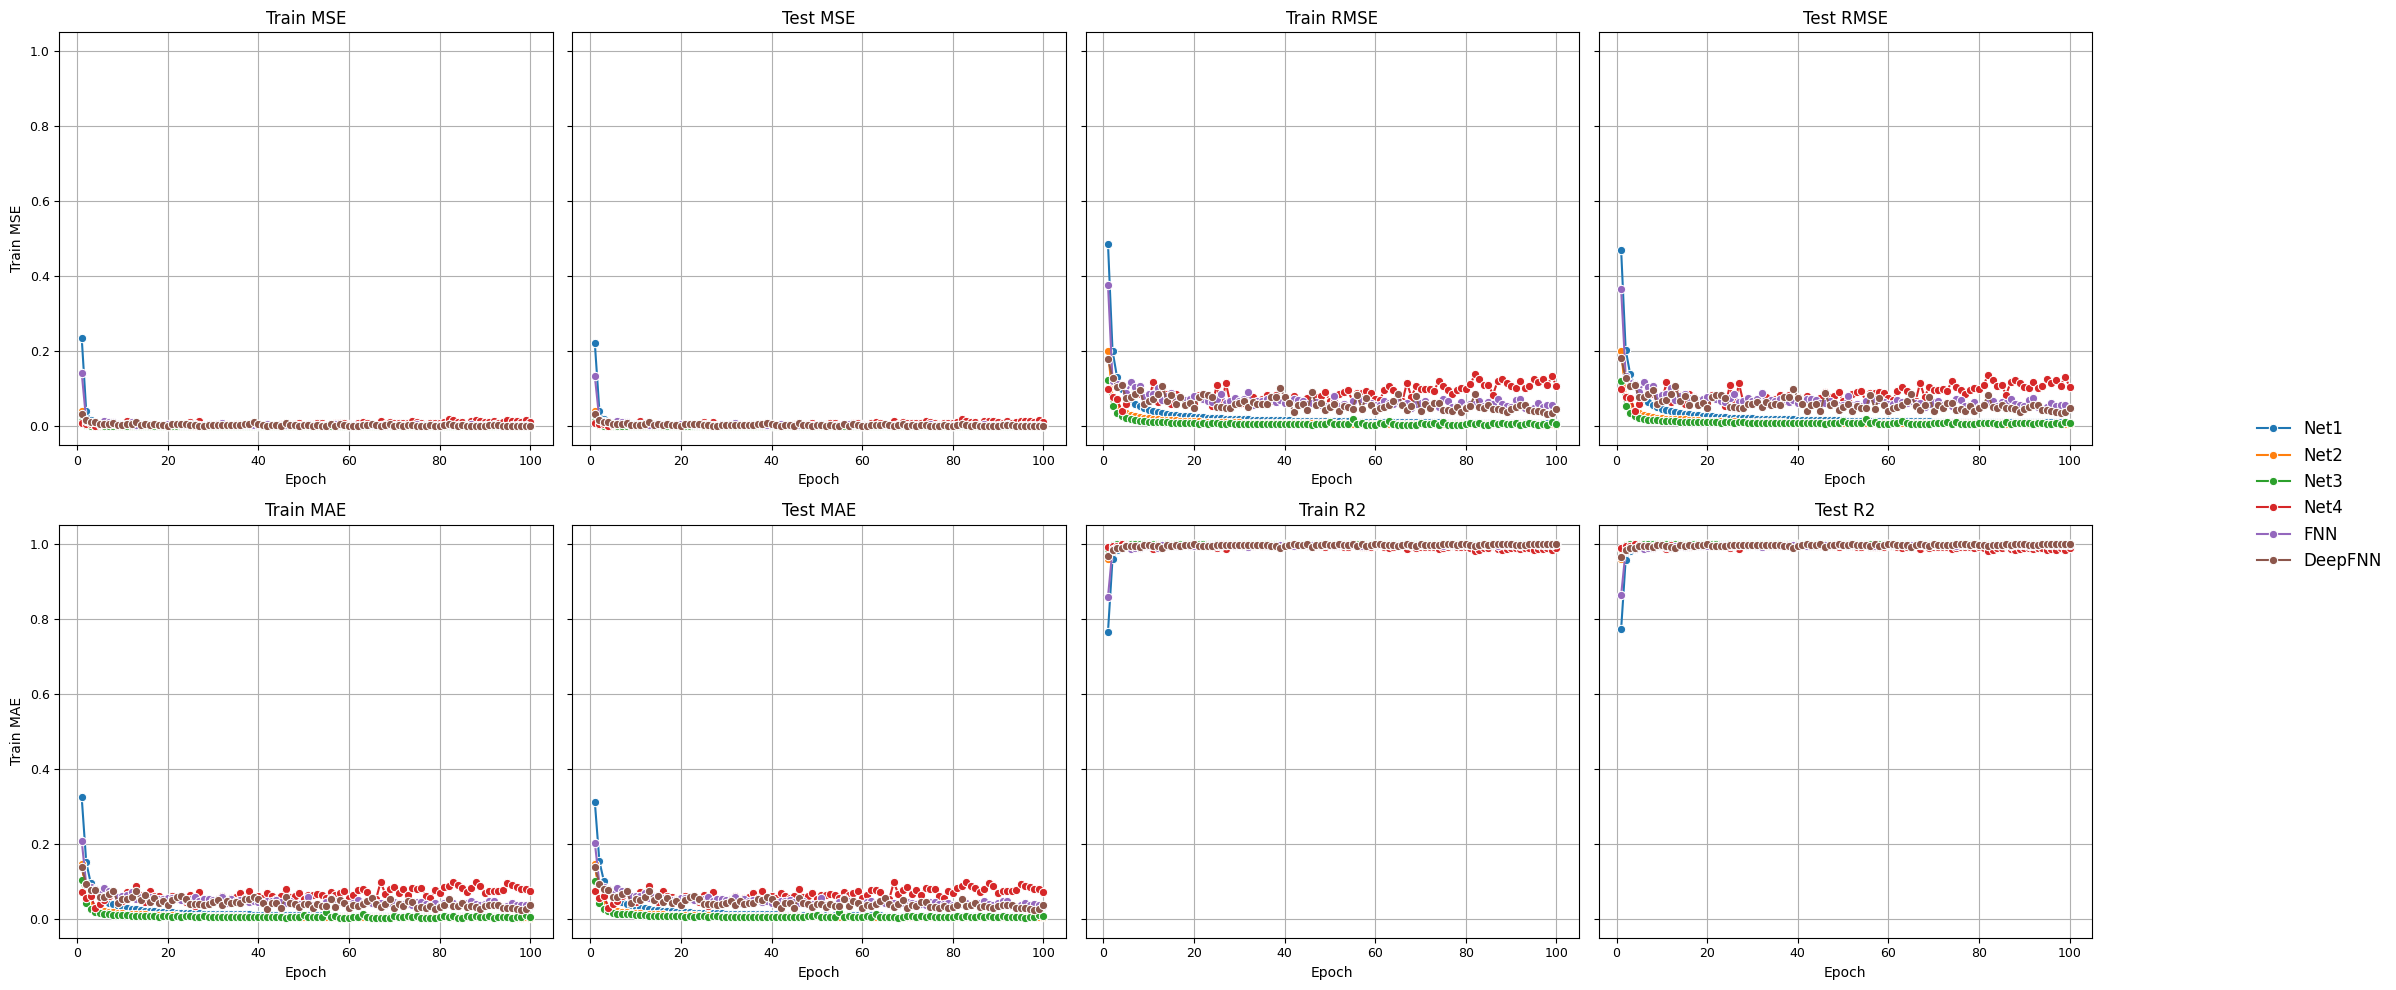

In [138]:
train_figures_tabular = {}

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 

train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [71]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [73]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=10,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:  10%|█████████                                                                                 | 1/10 [00:08<01:20,  8.99s/it]


Model: TCN | Epoch: 1/10
Train: MSE: 0.0120, RMSE: 0.1093, MAE: 0.0620, R2: 0.9881
Test:  MSE: 0.0161, RMSE: 0.1268, MAE: 0.0803, R2: 0.9889


Training TCN: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:28<00:00,  8.84s/it]



Model: TCN | Epoch: 10/10
Train: MSE: 0.0086, RMSE: 0.0927, MAE: 0.0445, R2: 0.9914
Test:  MSE: 0.0103, RMSE: 0.1014, MAE: 0.0566, R2: 0.9929


Training CNN1D:  10%|████████▊                                                                               | 1/10 [00:00<00:06,  1.44it/s]


Model: CNN1D | Epoch: 1/10
Train: MSE: 0.0947, RMSE: 0.3078, MAE: 0.1967, R2: 0.9053
Test:  MSE: 0.1253, RMSE: 0.3540, MAE: 0.2700, R2: 0.9135


Training CNN1D: 100%|███████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.46it/s]



Model: CNN1D | Epoch: 10/10
Train: MSE: 0.0187, RMSE: 0.1367, MAE: 0.0704, R2: 0.9813
Test:  MSE: 0.0202, RMSE: 0.1422, MAE: 0.0812, R2: 0.9860


Training GRUNet:  10%|████████▋                                                                              | 1/10 [00:00<00:06,  1.50it/s]


Model: GRUNet | Epoch: 1/10
Train: MSE: 0.0359, RMSE: 0.1895, MAE: 0.1002, R2: 0.9641
Test:  MSE: 0.0388, RMSE: 0.1969, MAE: 0.1145, R2: 0.9732


Training GRUNet: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]



Model: GRUNet | Epoch: 10/10
Train: MSE: 0.0156, RMSE: 0.1247, MAE: 0.0685, R2: 0.9844
Test:  MSE: 0.0178, RMSE: 0.1336, MAE: 0.0823, R2: 0.9877


Training RNNNet:  10%|████████▋                                                                              | 1/10 [00:00<00:03,  2.80it/s]


Model: RNNNet | Epoch: 1/10
Train: MSE: 0.0178, RMSE: 0.1334, MAE: 0.0633, R2: 0.9822
Test:  MSE: 0.0181, RMSE: 0.1346, MAE: 0.0713, R2: 0.9875


Training RNNNet: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.78it/s]



Model: RNNNet | Epoch: 10/10
Train: MSE: 0.0141, RMSE: 0.1188, MAE: 0.0653, R2: 0.9859
Test:  MSE: 0.0147, RMSE: 0.1212, MAE: 0.0713, R2: 0.9899


Training CNNLSTM:  10%|████████▌                                                                             | 1/10 [00:15<02:17, 15.28s/it]


Model: CNNLSTM | Epoch: 1/10
Train: MSE: 0.1326, RMSE: 0.3642, MAE: 0.2312, R2: 0.8674
Test:  MSE: 0.1393, RMSE: 0.3732, MAE: 0.2515, R2: 0.9038


Training CNNLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.55s/it]



Model: CNNLSTM | Epoch: 10/10
Train: MSE: 0.0303, RMSE: 0.1740, MAE: 0.0932, R2: 0.9697
Test:  MSE: 0.0330, RMSE: 0.1816, MAE: 0.1100, R2: 0.9772


Training BiLSTMNet:  10%|████████▍                                                                           | 1/10 [00:01<00:13,  1.51s/it]


Model: BiLSTMNet | Epoch: 1/10
Train: MSE: 0.0414, RMSE: 0.2034, MAE: 0.1055, R2: 0.9587
Test:  MSE: 0.0466, RMSE: 0.2159, MAE: 0.1290, R2: 0.9678


Training BiLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]



Model: BiLSTMNet | Epoch: 10/10
Train: MSE: 0.0169, RMSE: 0.1301, MAE: 0.0664, R2: 0.9831
Test:  MSE: 0.0192, RMSE: 0.1387, MAE: 0.0769, R2: 0.9867


Training DeepLSTMNet:  10%|████████▏                                                                         | 1/10 [00:02<00:21,  2.37s/it]


Model: DeepLSTMNet | Epoch: 1/10
Train: MSE: 0.0481, RMSE: 0.2193, MAE: 0.1131, R2: 0.9519
Test:  MSE: 0.0576, RMSE: 0.2400, MAE: 0.1442, R2: 0.9602


Training DeepLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.33s/it]



Model: DeepLSTMNet | Epoch: 10/10
Train: MSE: 0.0211, RMSE: 0.1451, MAE: 0.0754, R2: 0.9789
Test:  MSE: 0.0294, RMSE: 0.1715, MAE: 0.0951, R2: 0.9797


Training CNNBiLSTM:  10%|████████▍                                                                           | 1/10 [00:01<00:15,  1.74s/it]


Model: CNNBiLSTM | Epoch: 1/10
Train: MSE: 0.0354, RMSE: 0.1881, MAE: 0.1013, R2: 0.9646
Test:  MSE: 0.0364, RMSE: 0.1908, MAE: 0.1122, R2: 0.9749


Training CNNBiLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]



Model: CNNBiLSTM | Epoch: 10/10
Train: MSE: 0.0152, RMSE: 0.1234, MAE: 0.0633, R2: 0.9848
Test:  MSE: 0.0172, RMSE: 0.1313, MAE: 0.0724, R2: 0.9881


Training GRUCNN:  10%|████████▋                                                                              | 1/10 [00:00<00:07,  1.13it/s]


Model: GRUCNN | Epoch: 1/10
Train: MSE: 0.0497, RMSE: 0.2230, MAE: 0.1167, R2: 0.9503
Test:  MSE: 0.0552, RMSE: 0.2349, MAE: 0.1350, R2: 0.9619


Training GRUCNN: 100%|██████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]



Model: GRUCNN | Epoch: 10/10
Train: MSE: 0.0209, RMSE: 0.1444, MAE: 0.0770, R2: 0.9792
Test:  MSE: 0.0262, RMSE: 0.1618, MAE: 0.0912, R2: 0.9819


Training TCNLSTM:  10%|████████▌                                                                             | 1/10 [00:09<01:22,  9.15s/it]


Model: TCNLSTM | Epoch: 1/10
Train: MSE: 0.0300, RMSE: 0.1733, MAE: 0.0956, R2: 0.9700
Test:  MSE: 0.0385, RMSE: 0.1961, MAE: 0.1278, R2: 0.9735


Training TCNLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:30<00:00,  9.06s/it]



Model: TCNLSTM | Epoch: 10/10
Train: MSE: 0.0114, RMSE: 0.1067, MAE: 0.0546, R2: 0.9886
Test:  MSE: 0.0131, RMSE: 0.1146, MAE: 0.0667, R2: 0.9909


Training Seq2SeqLSTM:  10%|████████▏                                                                         | 1/10 [00:01<00:09,  1.04s/it]


Model: Seq2SeqLSTM | Epoch: 1/10
Train: MSE: 0.0430, RMSE: 0.2074, MAE: 0.1094, R2: 0.9570
Test:  MSE: 0.0456, RMSE: 0.2136, MAE: 0.1266, R2: 0.9685


Training Seq2SeqLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.05it/s]


Model: Seq2SeqLSTM | Epoch: 10/10
Train: MSE: 0.0202, RMSE: 0.1421, MAE: 0.0746, R2: 0.9798
Test:  MSE: 0.0300, RMSE: 0.1732, MAE: 0.0932, R2: 0.9793


In [74]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     10   0.016924  0.019240    0.130091   0.138709   0.066351   
1         CNN1D     10   0.018676  0.020220    0.136660   0.142198   0.070425   
2     CNNBiLSTM     10   0.015237  0.017231    0.123440   0.131269   0.063280   
3       CNNLSTM      9   0.028090  0.027323    0.167601   0.165297   0.094030   
4   DeepLSTMNet      9   0.021057  0.028215    0.145111   0.167973   0.072077   
5        GRUCNN     10   0.020852  0.026192    0.144403   0.161840   0.076967   
6        GRUNet     10   0.015561  0.017841    0.124744   0.133571   0.068472   
7        RNNNet      9   0.012718  0.013190    0.112776   0.114849   0.052777   
8   Seq2SeqLSTM      8   0.019376  0.023077    0.139197   0.151912   0.068548   
9           TCN      9   0.008517  0.009626    0.092286   0.098113   0.046697   
10      TCNLSTM     10   0.011388  0.013124    0.106714   0.114558   0.054641   

    Test MAE  Train R2   Test R2  
0   0.076857  0.983084  0.986718  
1   0.081158  0.981332  0.986041  
2   0.072445  0.984769  0.988104  
3   0.102472  0.971922  0.981138  
4   0.088299  0.978952  0.980522  
5   0.091240  0.979157  0.981918  
6   0.082285  0.984446  0.987683  
7   0.062779  0.987287  0.990894  
8   0.079486  0.980633  0.984069  
9   0.056001  0.991487  0.993355  
10  0.066653  0.988617  0.990940

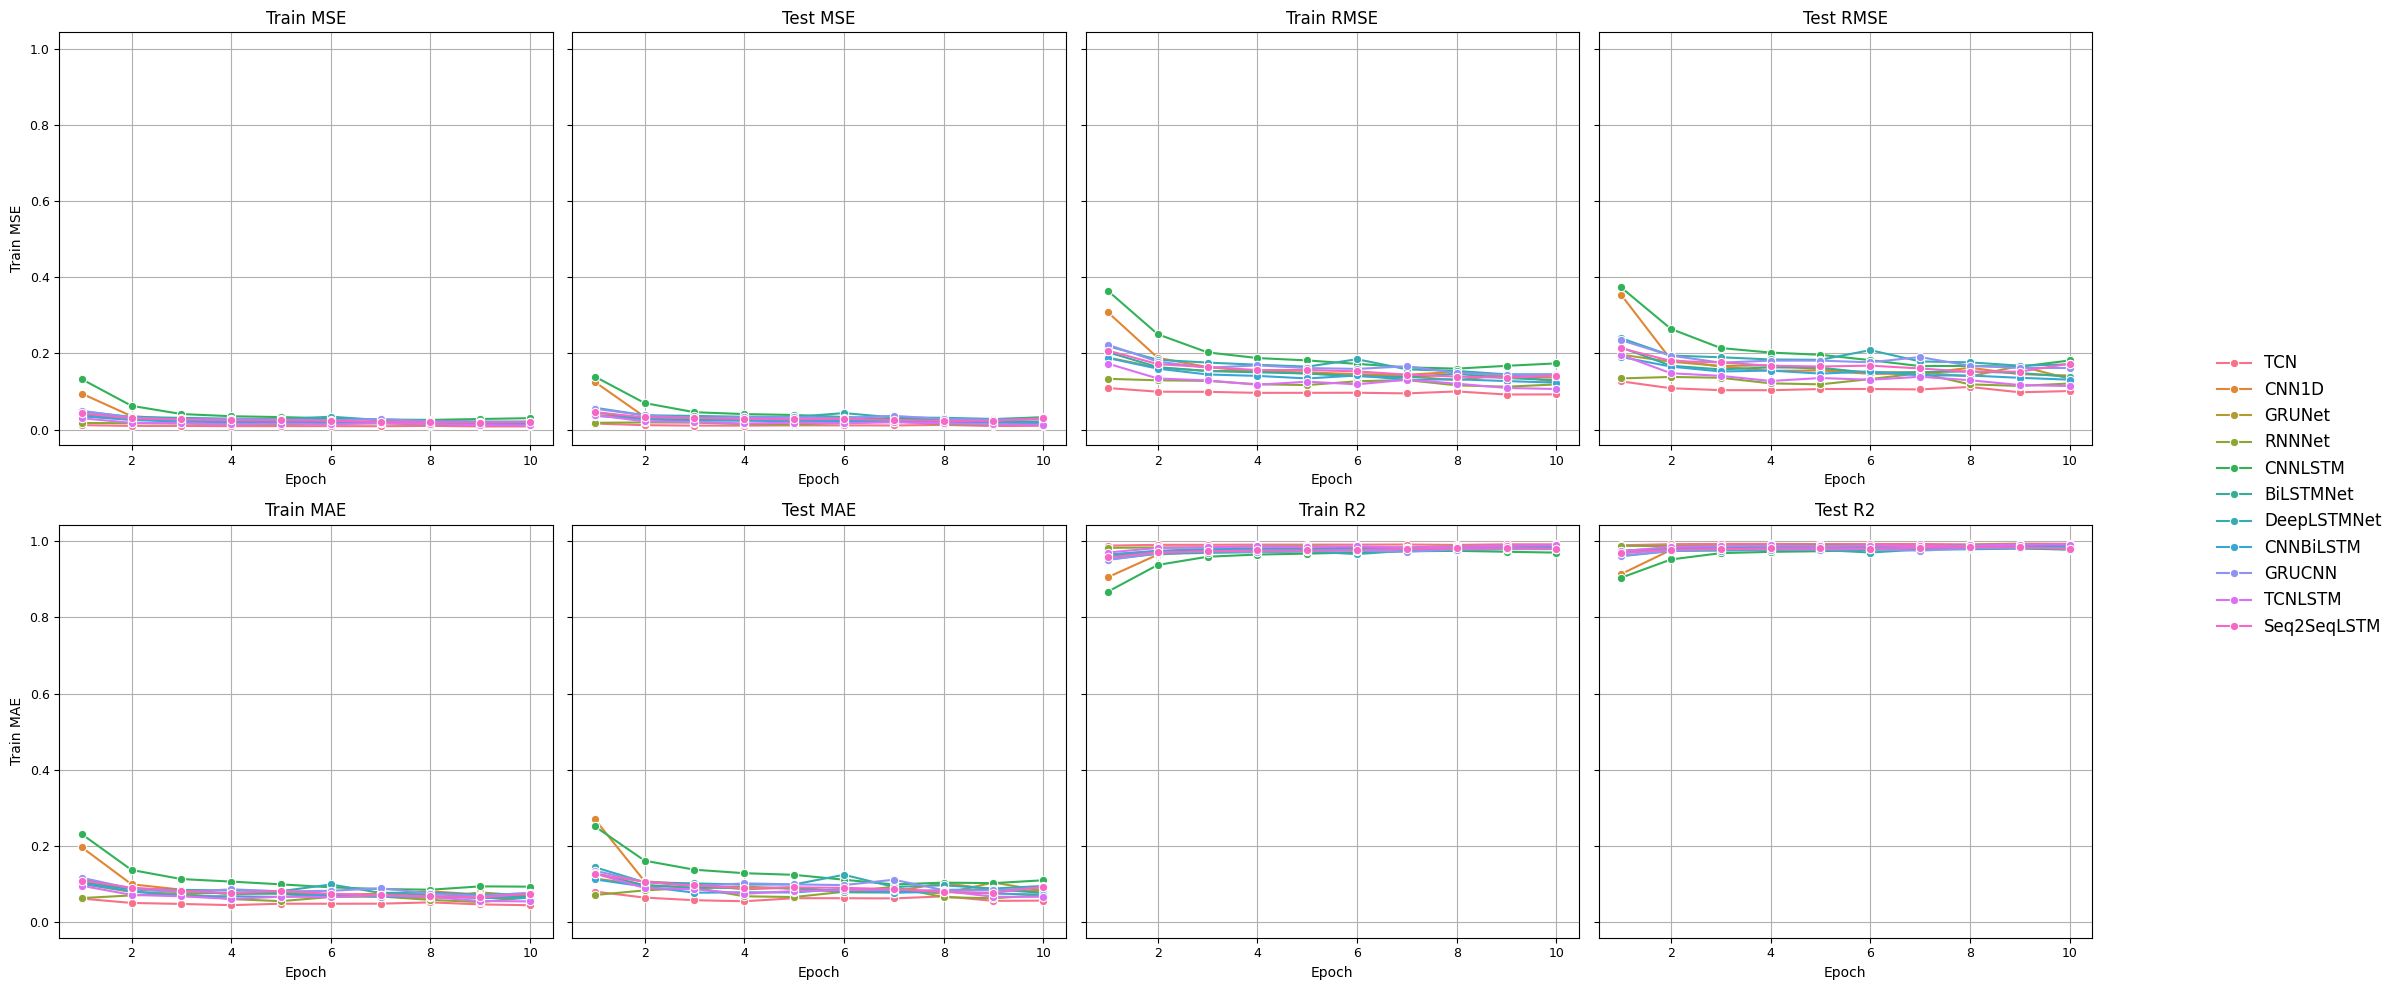

In [139]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]
df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

fig, axes = plt.subplots(2, 4, figsize=(24, 10), sharey=True)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric if i % 4 == 0 else "", fontsize=10) 
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

if handles and labels:
    fig.legend(handles, labels, loc='center right', fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.88, 1]) 

train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()


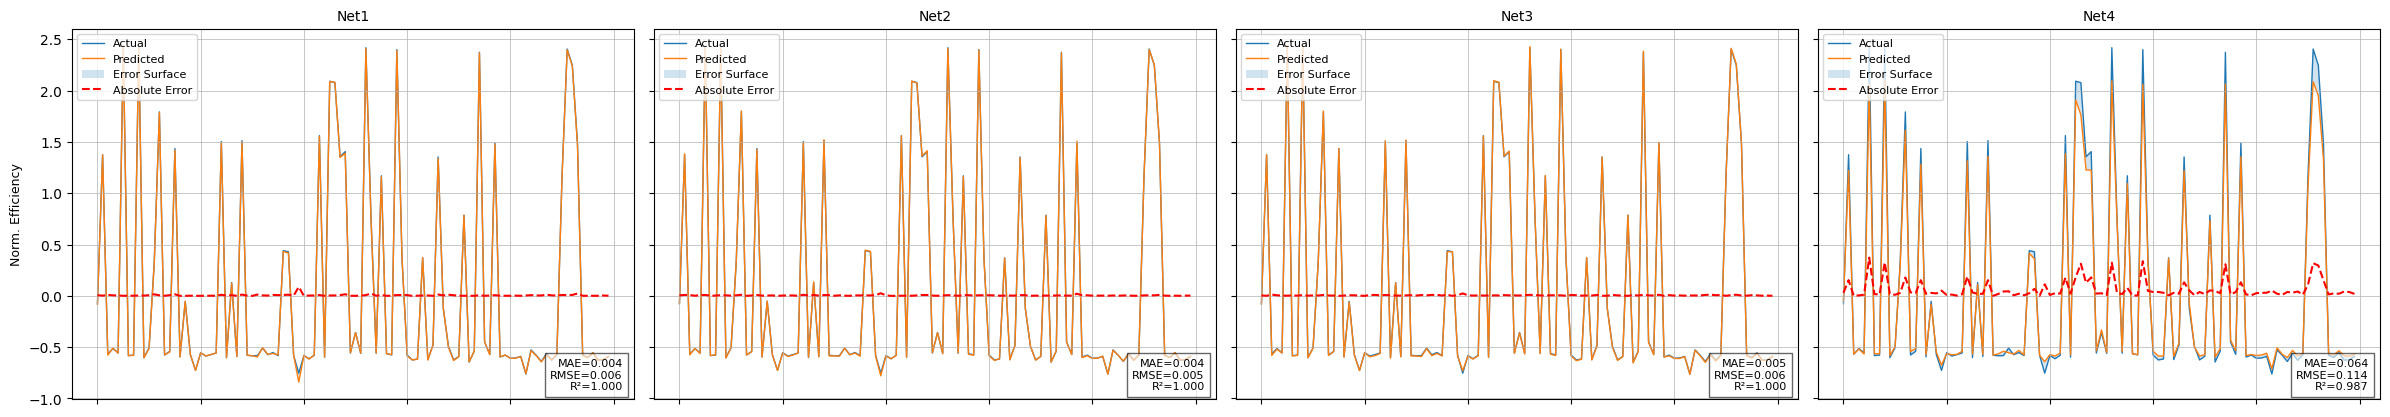

In [148]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()


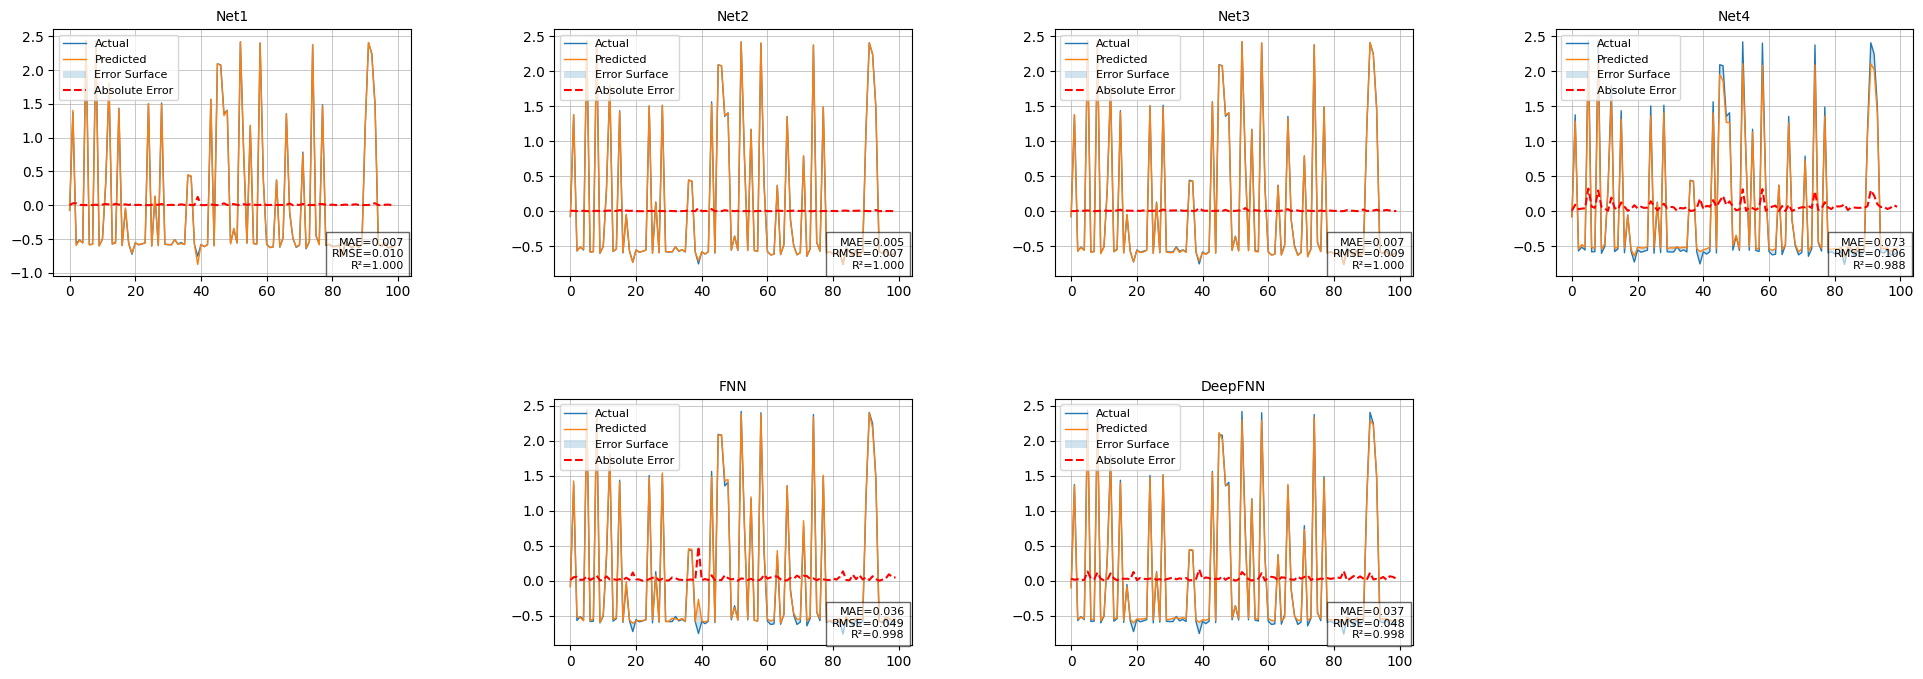

In [164]:
warnings.filterwarnings('ignore')

pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols = 4
nrows = (n_models + ncols - 1) // ncols

fig = plt.figure(figsize=(6 * ncols, 4 * nrows))
gs = gridspec.GridSpec(nrows, ncols)
gs.update(wspace=0.4, hspace=0.5)

axes = []

model_items = list(nets_tabular.items())
i = 0

for row in range(nrows):
    remaining = n_models - i
    plots_in_row = min(ncols, remaining)

    if plots_in_row < ncols:
        start = (ncols - plots_in_row) // 2
    else:
        start = 0

    for j in range(plots_in_row):
        col_span = 1
        ax = fig.add_subplot(gs[row, start + j])
        axes.append((ax, model_items[i][0], model_items[i][1]))  
        i += 1

for ax, name, model in axes:
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

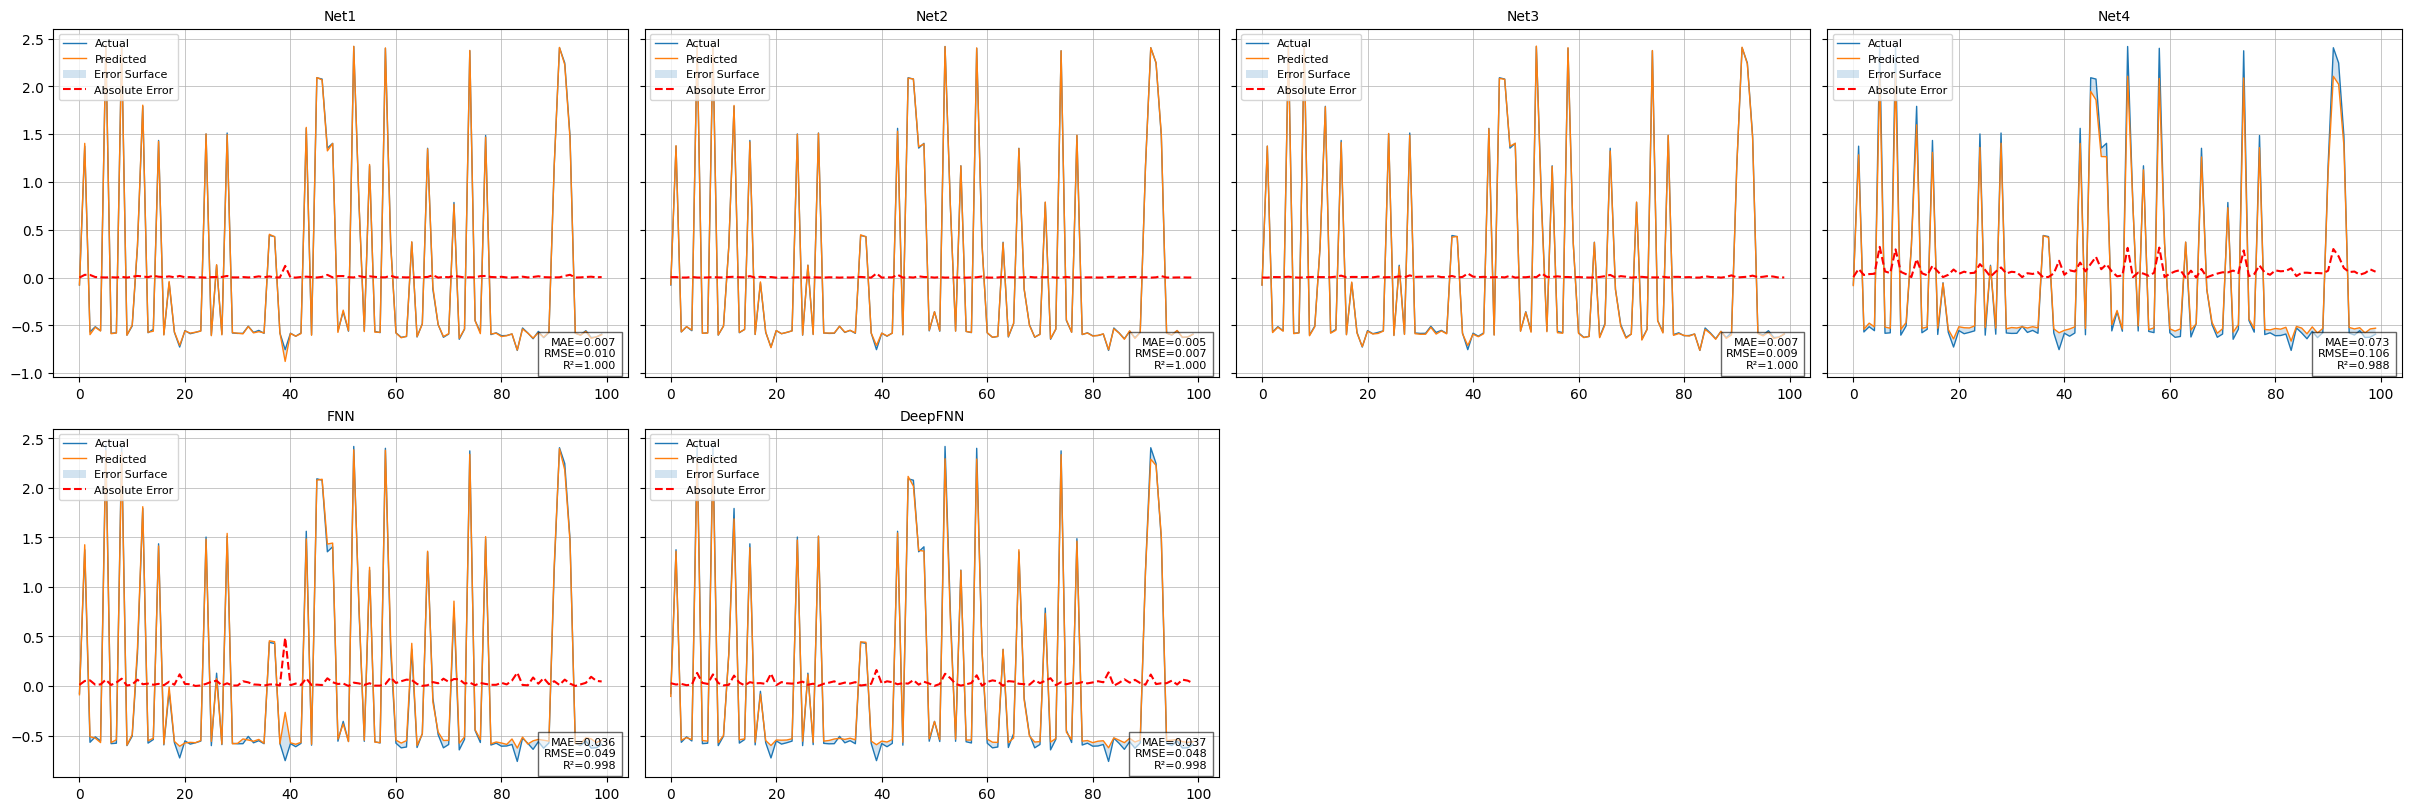

In [180]:
import warnings
import matplotlib.pyplot as plt
import numpy as np

warnings.filterwarnings('ignore')

pred_figures_nets_tab = {}

n_models = len(nets_tabular)
ncols = 4
nrows = (n_models + ncols - 1) // ncols

# Create figure with subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows),
                       constrained_layout=True, squeeze=False,
                       sharey='row')  # Share y-axis within each row

axs_flat = axs.ravel()  # Flatten the array for easy iteration

# First pass to collect all y-axis limits for each row
row_ylims = []
for row in range(nrows):
    row_min = np.inf
    row_max = -np.inf
    for col in range(ncols):
        idx = row * ncols + col
        if idx >= n_models:
            continue
        
        name, model = list(nets_tabular.items())[idx]
        model = model.to(device).eval()
        with torch.no_grad():
            X_in = reshape_input(model, X_test_tensor.to(device))
            preds = model(X_in).cpu().numpy().flatten()
            trues = y_test_tensor.cpu().numpy().flatten()
        
        avail = trues.shape[0]
        n_samples = min(100, avail)
        y_t = trues[-n_samples:]
        y_p = preds[-n_samples:]
        
        current_min = min(np.min(y_t), np.min(y_p))
        current_max = max(np.max(y_t), np.max(y_p))
        
        row_min = min(row_min, current_min)
        row_max = max(row_max, current_max)
    
    # Add some padding
    padding = (row_max - row_min) * 0.05
    row_ylims.append((row_min - padding, row_max + padding))

# Second pass to actually plot with shared y-axes
for i, (name, model) in enumerate(nets_tabular.items()):
    row = i // ncols
    col = i % ncols
    ax = axs[row, col]
    
    # Model prediction
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    # Prepare data for plotting
    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    # Plotting
    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    # Add metrics text
    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")
    
    # Set y-axis limits for the row
    ax.set_ylim(row_ylims[row])

# Hide any unused subplots
for j in range(n_models, nrows * ncols):
    axs_flat[j].axis('off')

pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

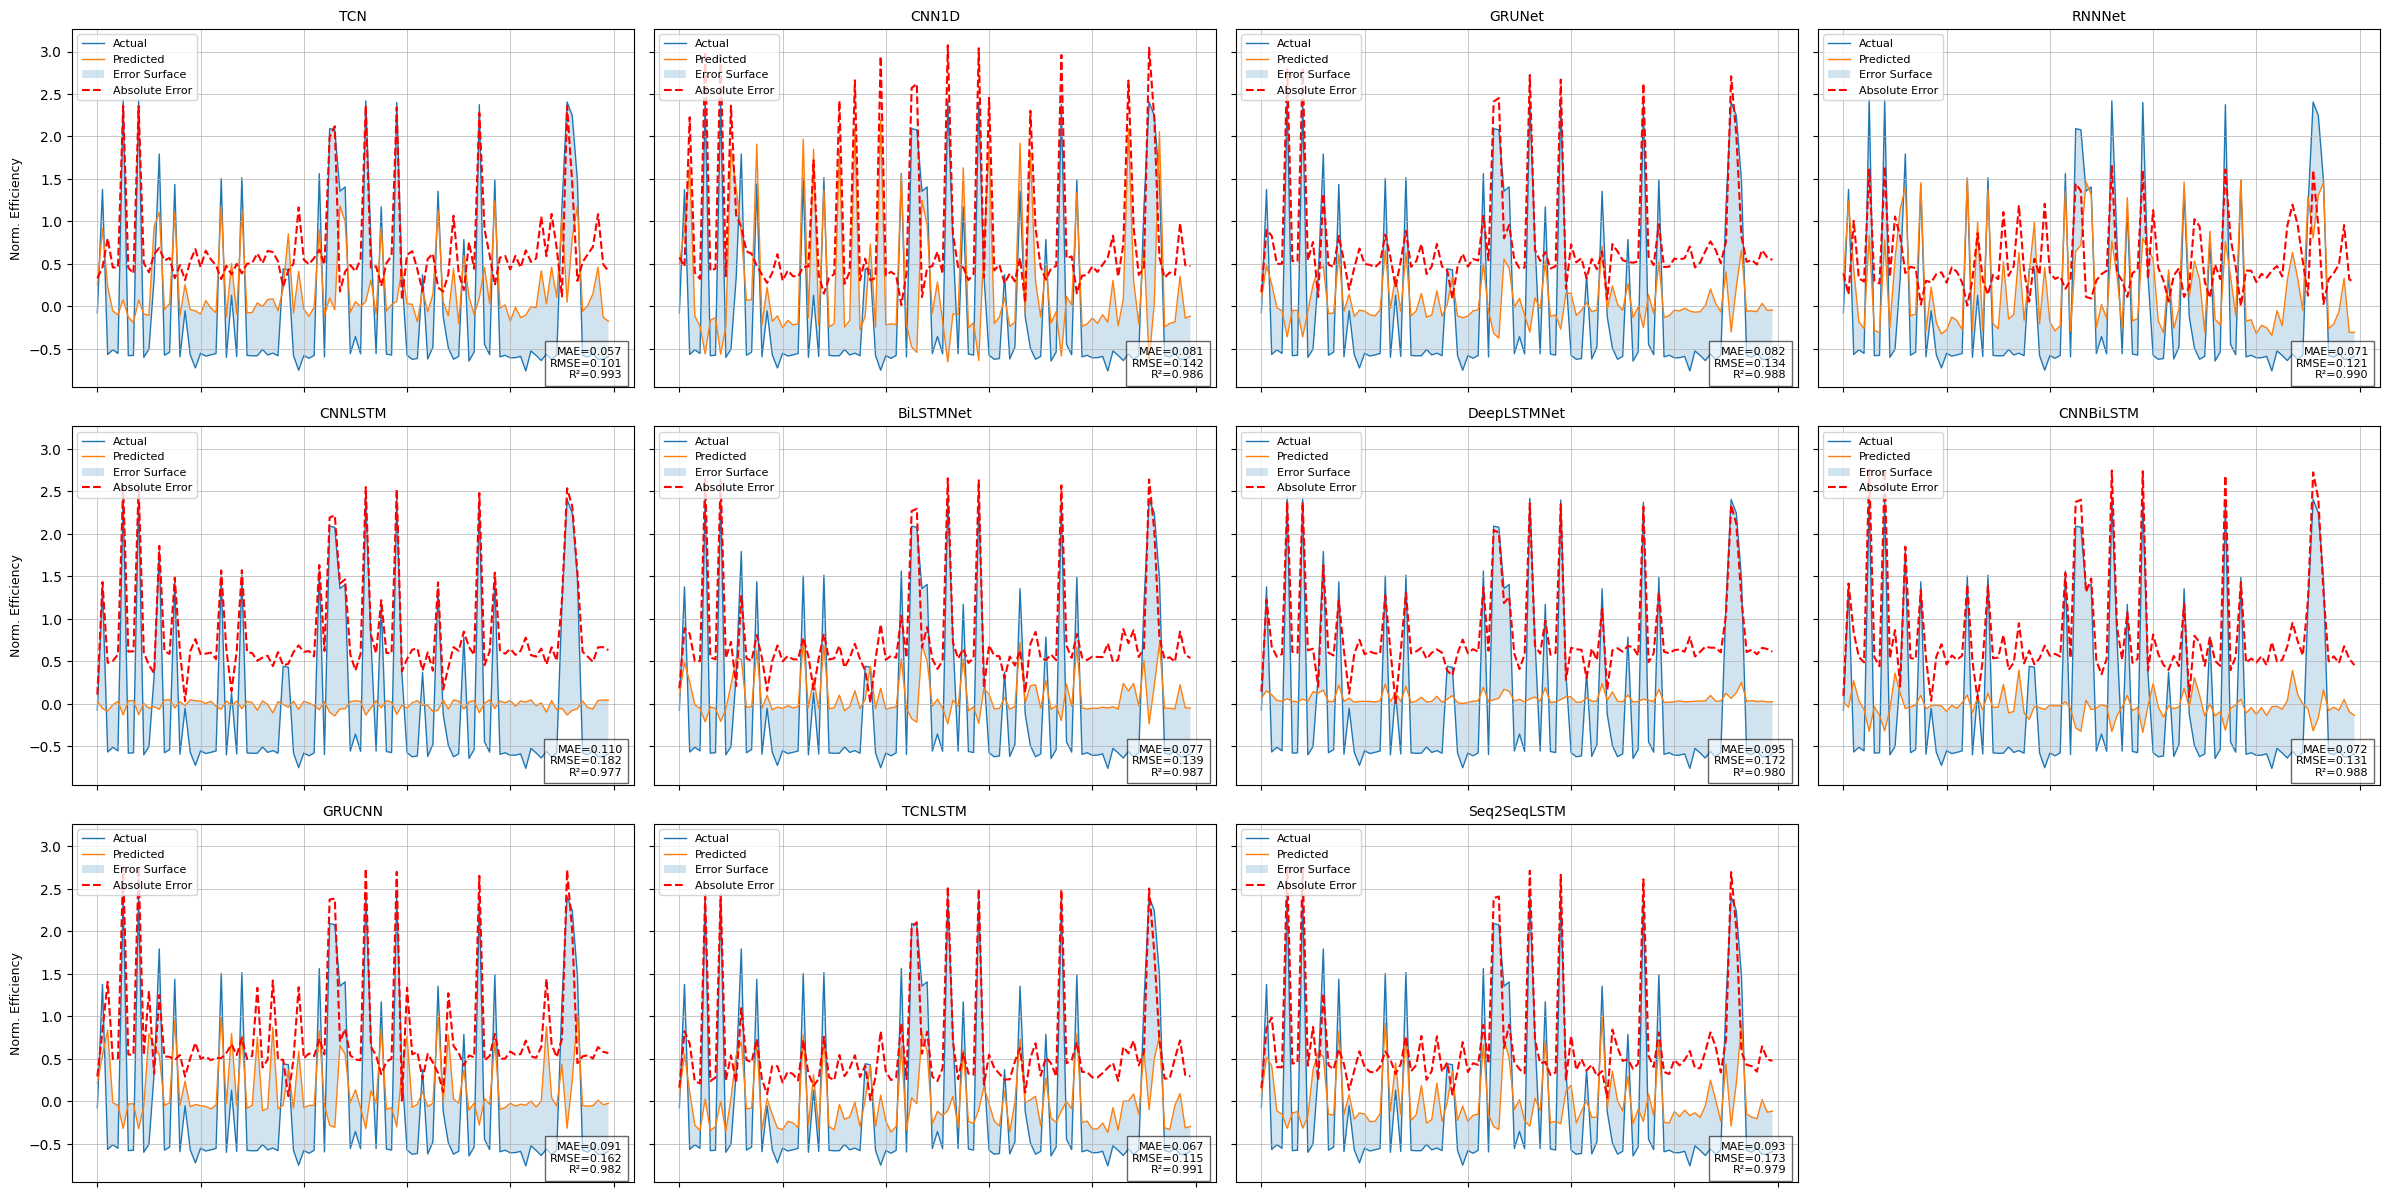

In [150]:
pred_figures_nets_ts = {}

n_models = len(ts_nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16), sharex=True, sharey=True)
axes = axes.flatten()

desired = 100
max_pts = 100

positions = []
full_rows = n_models // ncols
remainder = n_models % ncols

for r in range(full_rows):
    for c in range(ncols):
        positions.append(r * ncols + c)

if remainder:
    offset = (ncols - remainder) // 2
    for c in range(remainder):
        positions.append((full_rows * ncols) + offset + c)

for i, (name, model) in enumerate(ts_nets.items()):
    ax = axes[positions[i]]
    model = model.to(device).eval()

    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = nn_metrics_ts_df.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.02, stats, transform=ax.transAxes,
            ha='right', va='bottom', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if positions[i] % ncols == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if positions[i] // ncols == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()


In [152]:
for name, model in nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [153]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [154]:
for name, model in ts_nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )